In [34]:
import pickle
import sys
from pathlib import Path

import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from matplotlib.colors import ListedColormap
from skimage import exposure, measure

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [37]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as utils

In [38]:
csv_file = data_meta / "info_combined.csv"

# Read dataframe containing images information
df = pd.read_csv(csv_file)
df = df[df.After_bleach == False]

In [39]:
# Get shift between cycle
cycles = df.Cycle.unique()
conditions = df.Location.unique()

# Get contour 

In [44]:
# Load contours
contours_all, contours_nuclei_all = utils.load_pickle(data_meta / "contours.pickle")

In [53]:
seg = ["Hoeschst", "Phalloidin", "WGA"]
condition = conditions[0]

df_subset = df[(df.Location == condition)]
df_subset = df_subset[df_subset.Marker.isin(seg)]

In [54]:
# Read images
data = []
markers = []
for row in df_subset.itertuples():
    img = skimage.io.imread(row.Path)
    p2, p98 = np.percentile(img, (1, 99))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    mean = np.mean(img)
    img_rescale = cv2.subtract(img, np.ones(img.shape, dtype=img.dtype)*np.mean(img).astype(img.dtype))
    data.append(img_rescale)
    markers.append(row.Marker)
data = np.stack(data, axis=2)

# Extract max intensity
int_max = np.max(data, axis=(0, 1))
int_range = [[0, 0] for i in range(len(df_subset))]
for idx, level in enumerate(int_max):
    int_range[idx] = [0, level]
    

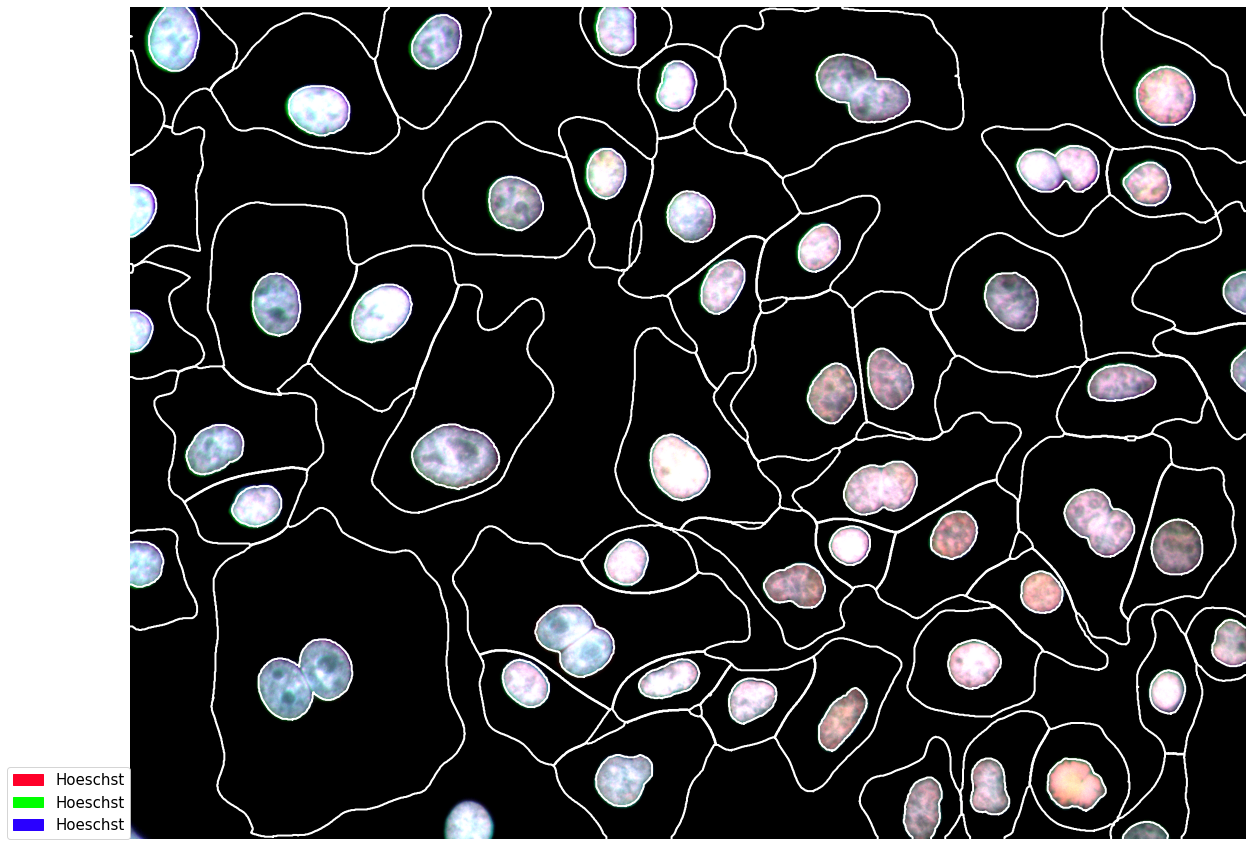

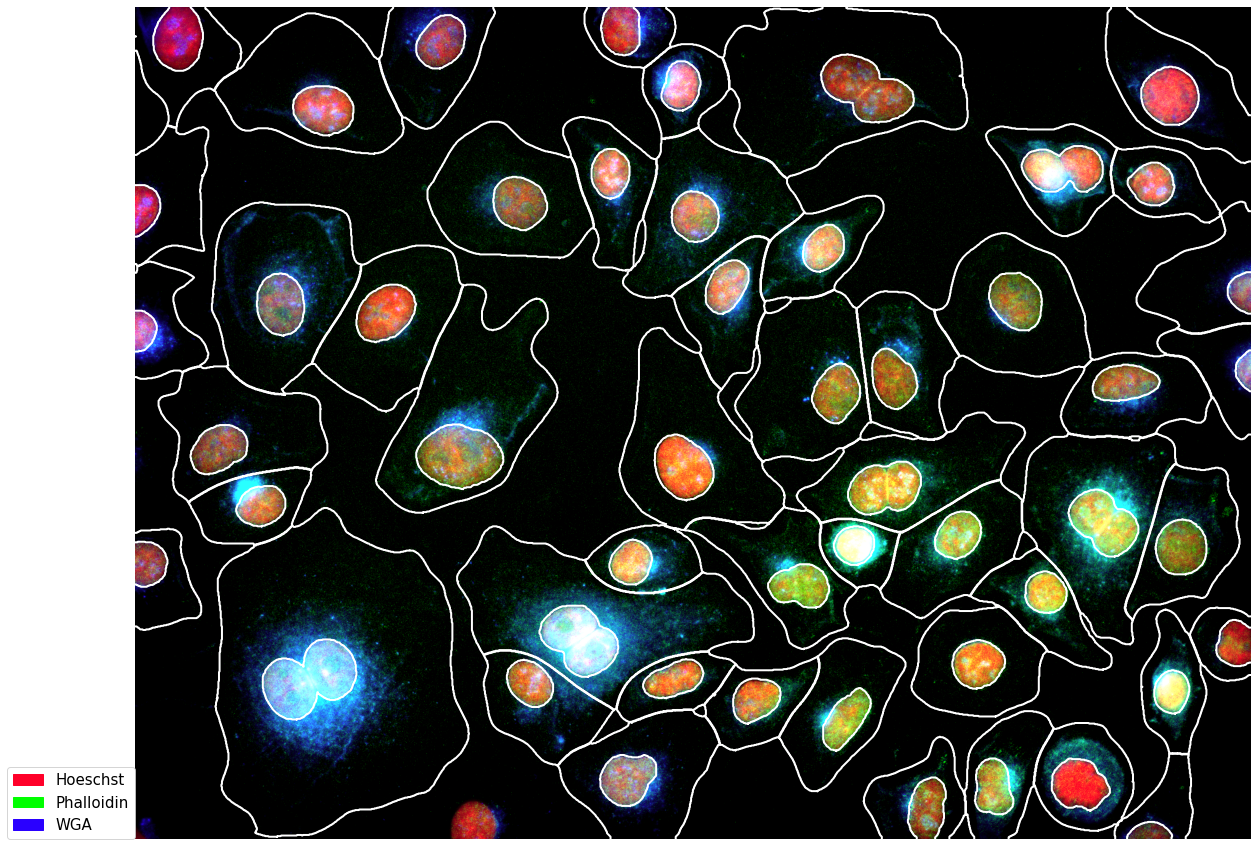

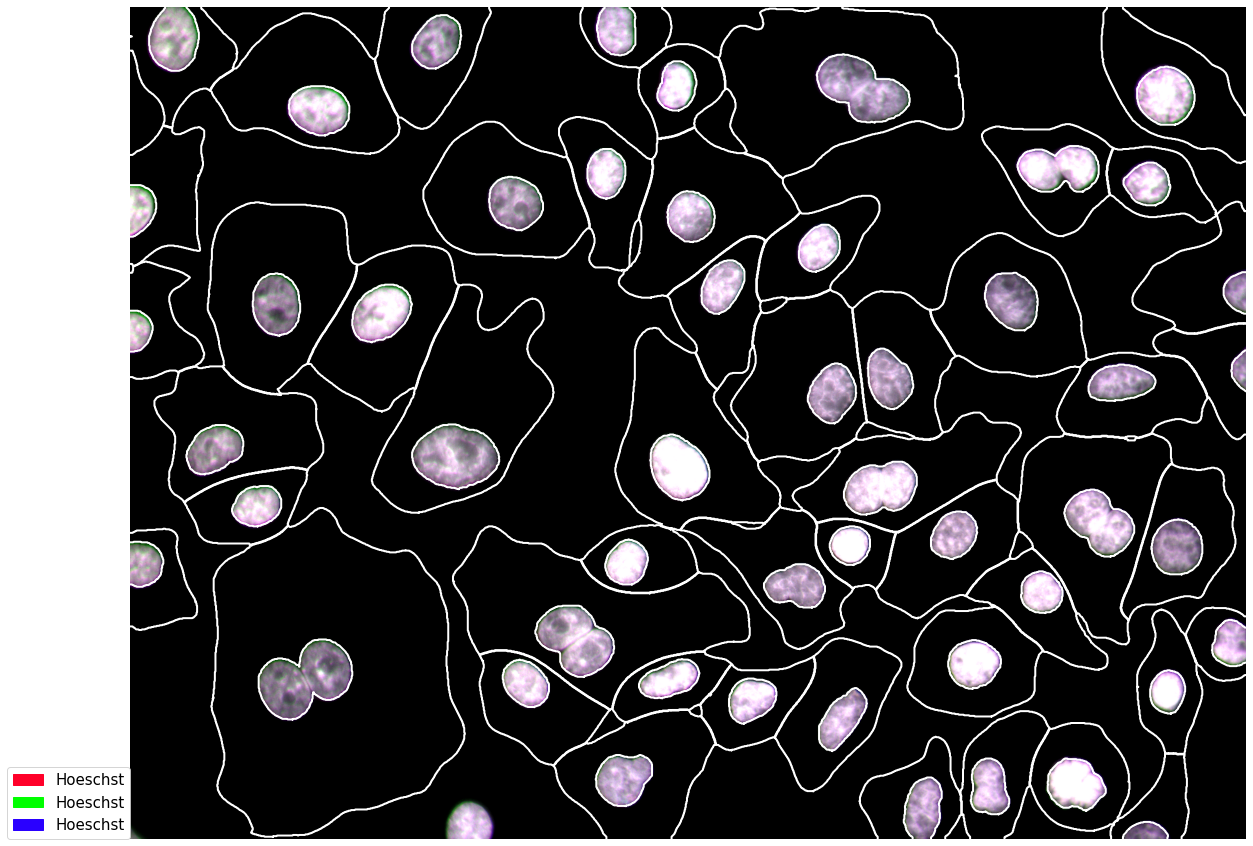

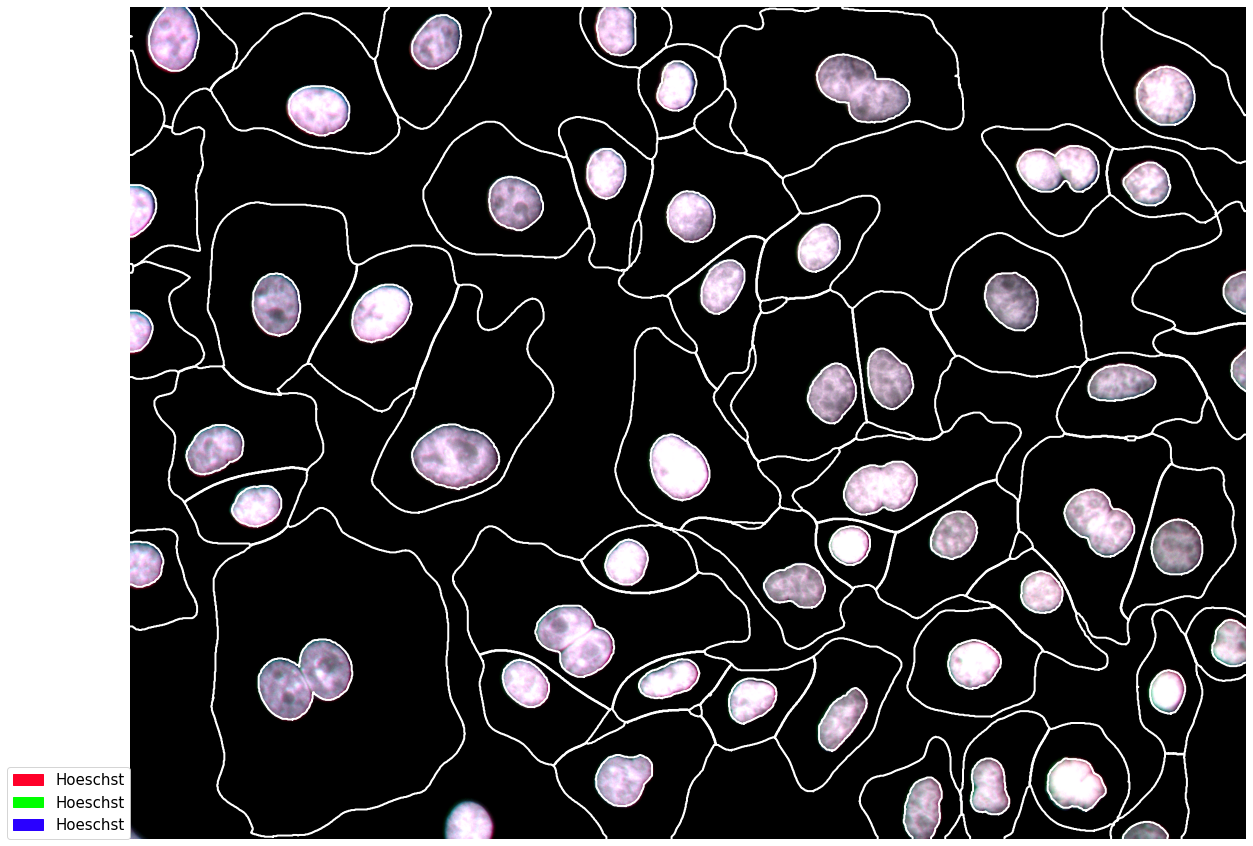

In [55]:
# Plot combined marker image 3 by 3 
n_group = 3
vals = np.linspace(0, 0.8, n_group)
my_color = plt.cm.gist_rainbow(vals)

for n in range(len(df_subset)//n_group):
    DEFAULT_CHANNELS = [n*3+i+1 for i in range(3)]
    RGB_MAP = {
        i: {"rgb": my_color[(i - 1) % 3][:3] * 255, "range": int_range[i - 1]}
        for i in DEFAULT_CHANNELS
    }
    
    fig, ax = plt.subplots(figsize=(20, 20))
    img = utils.convert_to_rgb(data, channels=DEFAULT_CHANNELS, rgb_map=RGB_MAP, vmax=255)
    ax.imshow(img)
    ax.axis("off")

    # plot contour
    utils.plot_contours(contours_all[str(condition)], ax)
    utils.plot_contours(contours_nuclei_all[str(condition)], ax)

    # Color legend
    patches = [
        mpatches.Patch(color=RGB_MAP[i]["rgb"] / 255.0, label=markers[i - 1])
        for i in DEFAULT_CHANNELS
    ]
    ax.legend(
        handles=patches,
        bbox_to_anchor=(0, 0),
        loc="lower right",
        borderaxespad=0.0,
        fontsize=15,
    )